In [ ]:
# Install dependancies
# Don't run this if you installed via requirements.txt
%pip install gymnasium numpy tensorflow matplotlib pygame shapely pydot graphviz Cope


In [1]:
# Imports
# %load_ext autoreload
# %autoreload 2

import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
import random
import time
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from SquareEnv import SquareEnv

2024-04-30 19:15:01.423806: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 19:15:01.424380: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 19:15:01.431510: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 19:15:01.517087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 19:15:03.295846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
# Configuration & Enviorment

# I don't need it to be determinisitic
# seed = 42

# Set up the enviorment
# After several hours messing with useless nested folders and __init__.py files, I gave up and
# just did it the way that makes sense instead of the way that appeals to the standard
# So instead of having useless nested directories, I just import directly from the file. I'm not
# intending to publish the enviorment by itself.
env = SquareEnv(
    N=11,
    render_mode="pygame",
    shift_rate=.05,
    rot_rate=.03,
    max_steps=300,
    bound_method='clip',
    flatten=True,
    boundary=2,
    max_overlap=.1
)

num_states = np.product(env.observation_space.shape)
print(f"Size of State Space -> {num_states}")
num_actions = np.product(env.action_space.shape)
print(f"Size of Action Space -> {num_actions}")

upper_bound = env.action_space.high
lower_bound = env.action_space.low

print(f"Max Value of an Action -> {upper_bound}")
print(f"Min Value of an Action -> {lower_bound}")


Size of State Space -> 33
Size of Action Space -> 33
Max Value of an Action -> [0.05 0.05 0.03 0.05 0.05 0.03 0.05 0.05 0.03 0.05 0.05 0.03 0.05 0.05
 0.03 0.05 0.05 0.03 0.05 0.05 0.03 0.05 0.05 0.03 0.05 0.05 0.03 0.05
 0.05 0.03 0.05 0.05 0.03]
Min Value of an Action -> [-0.05 -0.05 -0.03 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03
 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03
 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03]


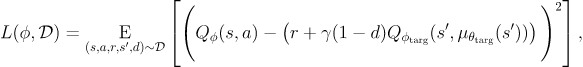

In [3]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, state, action, reward, next_state):
        # Set index to zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = state
        self.action_buffer[index] = action
        self.reward_buffer[index] = reward
        self.next_state_buffer[index] = next_state

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
        print('update called')
        # Training and updating Actor & Critic networks.
        with tf.GradientTape() as tape:
            # What we think we should do
            target_actions = target_actor(next_state_batch, training=True)
            # How good we think that is (the target Q-Network)
            target_evaluation = target_critic([next_state_batch, target_actions], training=True)
            y = reward_batch + gamma * target_evaluation
            critic_value = critic_model([state_batch, action_batch], training=True)
            # Get the average amount we were off by in predicting how well we would do, squared, and that's the loss
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        # print('critic gradients:')
        # print(critic_grad)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

# This updates target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [4]:
# Define Actor & Critic Models
# Tells a later cell to reset the weights (since we might have changed how we initialize them in this cell)
INIT_WEIGHTS = False

def get_actor():
    # Initialize weights
    # last_init = tf.random_uniform_initializer(minval=-env.shift_rate, maxval=env.shift_rate)
    # last_init = tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="leaky_relu")(inputs)
    out = layers.Dense(256, activation="leaky_relu")(out)
    # outputs = layers.Dense(num_actions, activation='softsign', kernel_initializer=last_init)(out)
    outputs = layers.Dense(num_actions, activation='softsign')(out)

    # This is rescale the output from between -1 - 1 to the appropriate action space scale
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    # model.summary()
    return model

# Exactly the same, but using Sequential, which I understand better
def get_actor_seq():
    # Initialize weights
    # last_init = tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3)
    last_init = tf.random_uniform_initializer(minval=-env.shift_rate, maxval=env.shift_rate)

    model = tf.keras.Sequential([
        layers.Dense(64, activation="leaky_relu", input_shape=(num_states,)),
        layers.Dense(128, activation="leaky_relu"),
        layers.Dense(256, activation="leaky_relu"),
        layers.Dense(64, activation="leaky_relu"),
        layers.Dense(num_actions, kernel_initializer=last_init),
        # layers.Dense(num_actions, activation='softmax'),
        # This is rescale the output from between -1 - 1 to the appropriate action space scale
        layers.Lambda(lambda x: x * upper_bound)
    ])

    # model.summary()
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="leaky_relu")(state_input)
    state_out = layers.Dense(32, activation="leaky_relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="leaky_relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="leaky_relu")(concat)
    out = layers.Dense(256, activation="leaky_relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    # model.summary()
    return model


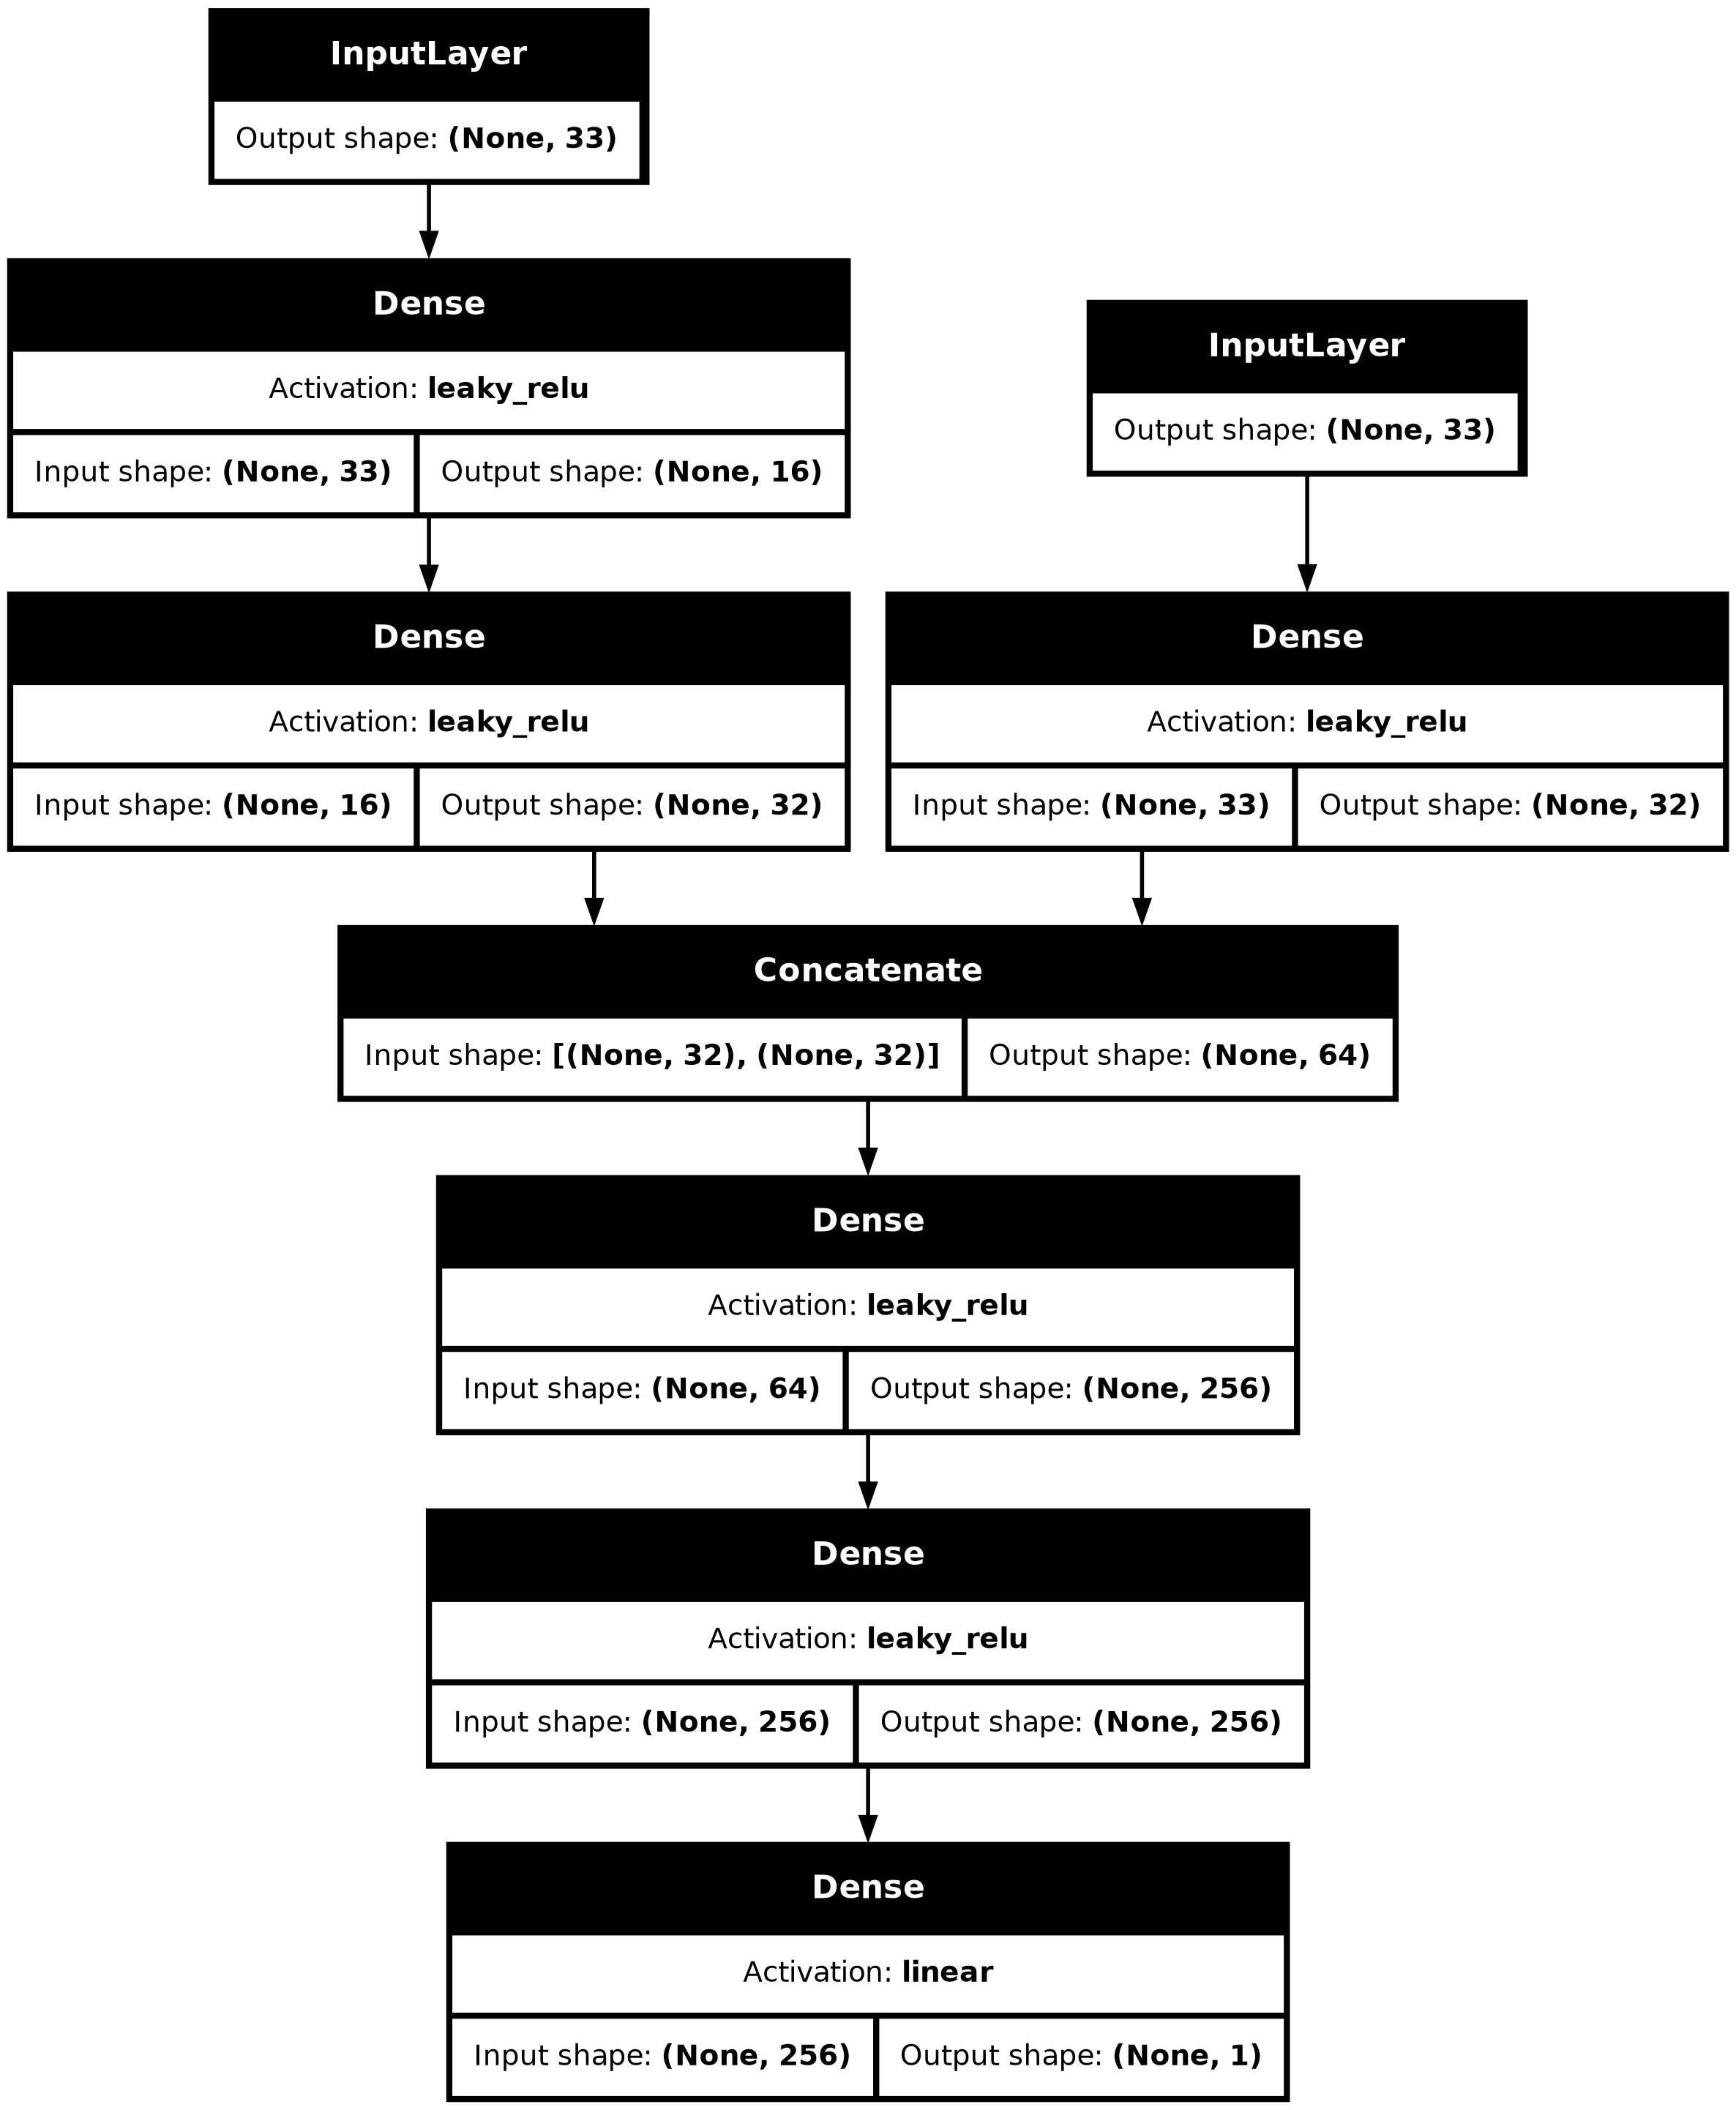

In [6]:
# Config
actor_weights_file = 'actor_weights'
critic_weights_file = 'critic_weights'

target_actor_weights_file = 'target_actor_weights'
target_critic_weights_file = 'target_critic_weights'

load_weights = False
loat_target_weights = False

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

if load_weights:
    actor_model.load_weights(actor_weights_file)
    critic_model.load_weights(critic_weights_file)

if loat_target_weights:
    target_actor.load_weights(target_actor_weights_file)
    target_critic.load_weights(target_critic_weights_file)
else:
    # Making the weights equal initially
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.0015

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

buffer = Buffer(50000, 64)

# How many resets we're running for.
total_episodes = 100
# Discount factor for future rewards
patience = gamma = 0.99
# Used to update target networks
tau = 0.005

std_dev = 0.2
# This used to be a custom OUActionNoise class, but it a paper came out saying that
# gaussian noise works just as well
noise = lambda std=std_dev: np.random.normal(scale=std, size=env.action_space.shape)
add_noise = True
noise_cooldown = actor_lr * 4

reset_weights = True

if not INIT_WEIGHTS:
    actor_model.save_weights('actor_model_init.weights.h5')
    critic_model.save_weights('critic_model_init.weights.h5')
    target_actor.save_weights('target_actor_init.weights.h5')
    target_critic.save_weights('target_critic_init.weights.h5')
    INIT_WEIGHTS = True


# ks.utils.plot_model(actor_model,   show_layer_activations=True, show_shapes=True)
ks.utils.plot_model(critic_model,  show_layer_activations=True, show_shapes=True)
# ks.utils.plot_model(target_actor,  show_layer_activations=True, show_shapes=True)
# ks.utils.plot_model(target_critic, show_layer_activations=True, show_shapes=True)


In [14]:
# Main Loop
import time
if reset_weights:
    actor_model.load_weights('actor_model_init.weights.h5')
    critic_model.load_weights('critic_model_init.weights.h5')
    target_actor.load_weights('target_actor_init.weights.h5')
    target_critic.load_weights('target_critic_init.weights.h5')

# To store reward history of each episode (for plotting)
ep_reward_list = []
# To store average reward history of last few episodes (for plotting)
avg_reward_list = []

try:
    # Run through `total_episodes` number of enviorment resets
    for ep in range(total_episodes):
        prev_state, _ = env.reset()
        # The env.search_space here (and after step()) is to normalize the values to within 0-1 so the NN can interpret them
        # Note that this assumes the search_space is greater than pi/2 (which shouldn't be a problem)
        prev_state = np.array([prev_state])/env.search_space
        episodic_reward = 0
        cnt = 0

        # Run/step through a single episodes
        while True:
            cnt += 1
            env.render()
            # Slow it down so I can see it doing things
            # time.sleep(.1)
            # Show the enviorment (comment this out to run headless)
            env.print(f'State: {prev_state}')

            # This is the policy -- deciding what action to take
            # Get the main actor output (i.e. "which action do I think we should take?")
            sampled_actions = tf.squeeze(actor_model(prev_state)).numpy()
            env.print(f'Action: {sampled_actions}')
            if add_noise:
                # This should make the noise fade out over time (proportional to the actor learning rate)
                # We want to fade the noise over time, *and* as we step through specific episodes
                total_cooldown   = max(std_dev - (ep  * noise_cooldown), 0)
                episode_cooldown = max(std_dev - (cnt * noise_cooldown), 0)
                sampled_actions += noise((total_cooldown + episode_cooldown) / 2)
                # sampled_actions += noise(max(std_dev - (cnt * noise_cooldown), 0))
                env.print(f'Action + noise: {sampled_actions}')

            # Make sure action is the action space
            action = np.clip(sampled_actions, lower_bound, upper_bound)

            # Recieve state and reward from environment.
            state, reward, done, _, info = env.step(action)
            state = np.array([state])/env.search_space
            env.print(f'Fresh State: {state}')

            buffer.record(prev_state, action, reward, state)
            episodic_reward += reward

            # This is where the Bellman equation is implemented
            buffer.learn()
            time.sleep(20)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

            if done:
                break

            prev_state = state

        # Episode is done, now do some calculations
        # These are all just for plotting, not actually important to the algorithm
        ep_reward_list.append(episodic_reward)
        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[-40:])
        avg_reward_list.append(avg_reward)
        print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))

finally:
    env.close()


AttributeError: in user code:

    File "/tmp/ipykernel_99968/3958703911.py", line 82, in update_target  *
        a.assign(b * tau + a * (1 - tau))

    AttributeError: 'SymbolicTensor' object has no attribute 'assign'


In [ ]:
# Plotting Episodes versus Avg. Rewards graph
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()


In [8]:
# Save the weights
actor_model.save_weights(actor_weights_file)
critic_model.save_weights(critic_weights_file)

target_actor.save_weights(target_actor_weights_file)
target_critic.save_weights(target_critic_weights_file)


ValueError: The filename must end in `.weights.h5`. Received: filepath=actor_weights